In [2]:
import random
import math
import numpy as np
import csv
from collections import deque



Inputing data and label data

In [1]:
import numpy as np
from simulation import Simulation
X = []  # inout probability grid
y = []  # number of moves
GRID_SIZE = 30
for _ in range(100):  
    simulation = Simulation()
    bot_knowledge_base_grid, probabilities_grid, moves = simulation.run()

    probabilities_grid = np.array(probabilities_grid, dtype=np.float32)
    bot_knowledge_base_grid = np.array(bot_knowledge_base_grid, dtype=np.float32)

    # Stack the grids along the channel dimension
    combined_input = np.stack([probabilities_grid, bot_knowledge_base_grid], axis=-1)

    X.append(combined_input)
    y.append(moves)

# Convert to NumPy arrays
X = np.array(X)  # Shape: (num_samples, GRID_SIZE, GRID_SIZE, 2)
y = np.array(y)

print("Input Shape:", X.shape)  # Should be (num_samples, GRID_SIZE, GRID_SIZE, 2)
print("Labels Shape:", y.shape)  # Should be (num_samples,)


Bot Location: (24, 6)
Rat Location: (3, 27)
Final moves taken:56
Bot Location: (10, 22)
Rat Location: (28, 23)
Final moves taken:74
Bot Location: (7, 3)
Rat Location: (23, 25)
Final moves taken:42
Bot Location: (5, 1)
Rat Location: (13, 25)
Final moves taken:80
Bot Location: (1, 13)
Rat Location: (14, 19)
Final moves taken:43
Bot Location: (28, 19)
Rat Location: (7, 13)
Final moves taken:23
Bot Location: (21, 19)
Rat Location: (21, 1)
Final moves taken:47
Bot Location: (26, 7)
Rat Location: (24, 6)
Final moves taken:65
Bot Location: (1, 27)
Rat Location: (7, 20)
Final moves taken:55
Bot Location: (22, 10)
Rat Location: (27, 6)
Final moves taken:35
Bot Location: (14, 22)
Rat Location: (23, 10)
Final moves taken:46
Bot Location: (8, 6)
Rat Location: (8, 18)
Final moves taken:73
Bot Location: (1, 23)
Rat Location: (6, 26)
Final moves taken:48
Bot Location: (21, 17)
Rat Location: (9, 6)
Final moves taken:45
Bot Location: (15, 28)
Rat Location: (14, 25)
Final moves taken:98
Bot Location: (2

Create / build the NN, Train the model

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 1.7214 - mae: 0.2589 - val_loss: 1.5194 - val_mae: 0.1394
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.4745 - mae: 0.1330 - val_loss: 1.3102 - val_mae: 0.1305
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.2674 - mae: 0.1174 - val_loss: 1.1286 - val_mae: 0.1666
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.0825 - mae: 0.1162 - val_loss: 0.9621 - val_mae: 0.1746
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.9184 - mae: 0.1106 - val_loss: 0.8093 - val_mae: 0.1469
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.7744 - mae: 0.1092 - val_loss: 0.6778 - val_mae: 0.1279
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.6485 - mae: 0.1101 - val_loss: 0.5696 - val_mae: 0.1365
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.5399 - mae: 0.0990 - val_loss: 0.4757 - val_mae: 0.1333
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.4505 - mae: 0.1046 -

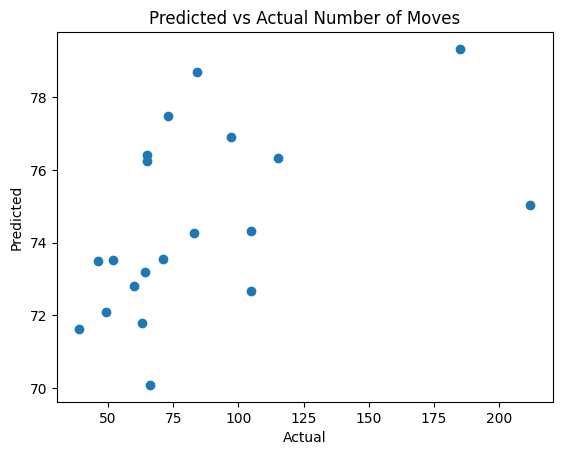

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

y_max = y.max()
y_normalized = y / y_max

# splitting the data for testing and training 
X_train, X_val, y_train, y_val = train_test_split(X, y_normalized, test_size=0.2, random_state=42)

model = models.Sequential([
    layers.Input(shape=(GRID_SIZE, GRID_SIZE, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)), #basic features are captujred
    layers.MaxPooling2D((2, 2)), 
    layers.Dropout(0.50), #avoiding overfitting
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(1, activation='linear')
])


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

#adam optimizer and huber loss functions are used here
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='huber', metrics=['mae'])

# Training the model with validation data
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

#evaluating model 
val_loss, val_mae = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Mean Absolute Error:", val_mae)

#predicted vs actual plot
predictions = model.predict(X_val) * y_max  
actuals = y_val * y_max 

plt.scatter(actuals, predictions)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Number of Moves')
plt.show()


Evaluating the model

In [6]:
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0657 - mae: 0.1113
Validation Loss: 0.06565167009830475, Validation MAE: 0.11132298409938812


Visualise training

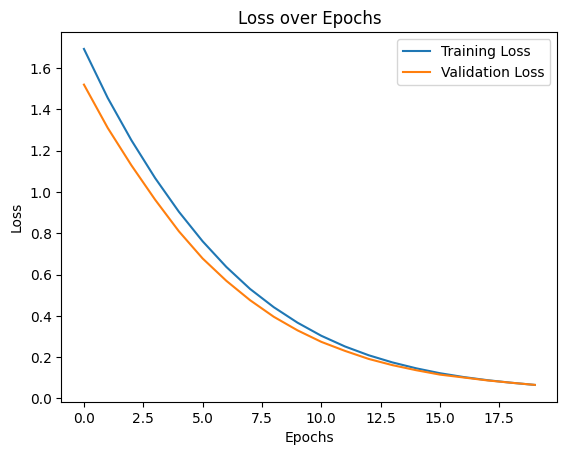

In [7]:
import matplotlib.pyplot as plt

# Plot loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


Make predictions

In [8]:
# Simulate a new run
simulation = Simulation()
bot_knowledge_base_grid, probabilities_grid, actual_moves = simulation.run()

# Prepare the input for prediction
probabilities_grid = np.array(probabilities_grid, dtype=np.float32)
bot_knowledge_base_grid = np.array(bot_knowledge_base_grid, dtype=np.float32)

# Stack the inputs along the channel dimension
test_input = np.stack([probabilities_grid, bot_knowledge_base_grid], axis=-1).reshape(1, GRID_SIZE, GRID_SIZE, 2)

# Predict the number of moves
predicted_moves = model.predict(test_input) * y_max  # Scale back the prediction
print(f"Predicted Moves: {predicted_moves[0][0]:.2f}")
print(f"Actual Moves: {actual_moves}")


Bot Location: (21, 7)
Rat Location: (18, 23)
Final moves taken:73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted Moves: 79.26
Actual Moves: 73


save the model

In [9]:
model.save('rat_bot_model.keras')


using saved model

In [ ]:

loaded_model = tf.keras.models.load_model('rat_bot_model.keras')
predicted_moves_loaded = loaded_model.predict(test_input)
print(f"Predicted Moves (Loaded Model): {predicted_moves_loaded[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted Moves (Loaded Model): 64.64
